In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn import manifold
import pyrootutils
import hydra

pyrootutils.set_root(os.path.abspath(".."), pythonpath=True)
    
from src.utils.data import load_news
from src.utils.hydra import RunCollection
from src.utils.notebook import get_figsize

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})


In [2]:
with hydra.initialize(version_base=None, config_path="../conf"):
    cfg = hydra.compose(config_name="notebook")

In [3]:
runs = RunCollection.from_path("../outputs")
runs = runs.filter_by_job("train_embeddings")
run = runs.one()
run.show_config()

seed: 515
epochs: 10
embedding_dim: 100
batch_size: 128
learning_rate: 0.001
n_negative_samples: 4
data:
  seed: 468
  num_users: 200000
  source: large
  target: ${data.num_users}_${data.seed}
  mind_variant: ${data.target}



In [4]:
metrics = pd.read_csv(run.get_file_path("metrics.csv"))
metrics

,P@1,P@5,MRR,FMI,Silhouette,Train loss,epoch
0,0.000,0.000,0.073282,0.287594,0.297637,0.903918,0
1,0.000,0.500,0.172520,0.284227,0.413630,0.438126,1
2,0.000,0.500,0.209265,0.283156,0.444662,0.414427,2
3,0.125,0.750,0.339576,0.278538,0.455532,0.397396,3
4,0.000,0.625,0.219583,0.280536,0.457033,0.385194,4
5,0.000,0.500,0.203013,0.275973,0.463143,0.374783,5
6,0.000,0.500,0.196939,0.274677,0.446814,0.365187,6
7,0.000,0.500,0.193173,0.271252,0.438696,0.356269,7
8,0.000,0.500,0.173803,0.266217,0.423577,0.347888,8
9,0.000,0.375,0.167285,0.266011,0.419336,0.340088,9


In [5]:
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
topic_embeddings

Using topic embeddings from epoch 3


,subcategory,embedding
0,ads-latingrammys,"[-0.5279844, 1.2566609, 0.09642819, -0.2321693..."
1,ads-lung-health,"[0.07290848, -0.108872466, -0.116296835, 0.058..."
2,advice,"[-0.07572569, -0.05586439, -0.103811264, -0.10..."
3,animals,"[0.114049695, -0.09510901, -0.15006417, -0.116..."
4,autosbuying,"[0.012851537, 0.12294536, -0.030278068, 0.0524..."
...,...,...
249,weightloss,"[-0.075820275, -1.4854307e-05, 0.16013281, -0...."
250,wellness,"[-0.018470695, -0.04485918, 0.08147979, -0.051..."
251,wines,"[-1.0180085, -0.6784834, -0.5070956, -0.352719..."
252,wonder,"[0.11814448, -0.012971732, -0.12646337, -0.029..."


In [6]:
mind_variant = run.config.data.mind_variant
news = load_news(mind_variant, columns=["category", "subcategory"], data_dir=cfg.data_dir)
news = news.drop(columns="split")
categories = news.reset_index(drop=True).drop_duplicates()
categories = categories.merge(topic_embeddings, on="subcategory")
categories

,category,subcategory,embedding
0,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
1,health,weightloss,"[-0.075820275, -1.4854307e-05, 0.16013281, -0...."
2,health,medical,"[-0.067902386, -0.12158826, 0.06461111, -0.042..."
3,news,newsworld,"[0.028403273, -0.03802452, -0.08220867, 0.0200..."
4,health,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07..."
...,...,...,...
266,sports,soccer_videos,"[-0.97039086, 0.5559175, -1.0110803, 0.3310985..."
267,lifestyle,relationships,"[1.4300101, -0.51480174, 1.3971273, 0.66752815..."
268,autos,autosconvertibles,"[1.8388319, 1.0420269, 0.40700355, 0.23218808,..."
269,sports,olympics-videos,"[-0.3969354, -0.6827047, -1.0807043, -0.829718..."


In [7]:
embeddings = np.stack(categories["embedding"].values)
seed = 1234
tsne = manifold.TSNE(n_components=2, random_state=seed)
tsne_embeddings = tsne.fit_transform(embeddings)
categories["tsne_x"] = tsne_embeddings[:,0]
categories["tsne_y"] = tsne_embeddings[:,1]
categories

,category,subcategory,embedding,tsne_x,tsne_y
0,lifestyle,lifestyleroyals,"[-0.05900184, -0.11635385, 0.0978779, -0.09877...",-6.081984,3.694923
1,health,weightloss,"[-0.075820275, -1.4854307e-05, 0.16013281, -0....",-5.766572,8.497058
2,health,medical,"[-0.067902386, -0.12158826, 0.06461111, -0.042...",-1.007333,1.962675
3,news,newsworld,"[0.028403273, -0.03802452, -0.08220867, 0.0200...",3.467708,-0.209973
4,health,voices,"[-0.04590325, -0.056500547, 0.045242723, -0.07...",-1.544950,2.837503
...,...,...,...,...,...
266,sports,soccer_videos,"[-0.97039086, 0.5559175, -1.0110803, 0.3310985...",1.147251,-11.767459
267,lifestyle,relationships,"[1.4300101, -0.51480174, 1.3971273, 0.66752815...",1.632193,5.407600
268,autos,autosconvertibles,"[1.8388319, 1.0420269, 0.40700355, 0.23218808,...",-2.374385,-7.482102
269,sports,olympics-videos,"[-0.3969354, -0.6827047, -1.0807043, -0.829718...",1.962325,8.349317


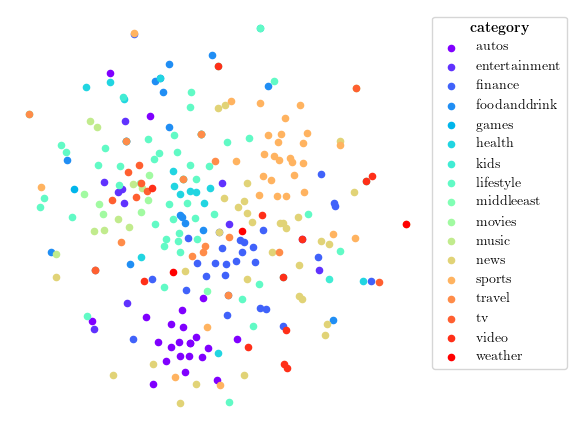

In [8]:
fig, ax = plt.subplots(figsize=get_figsize(fraction=0.8, aspect_ratio=1))
colors = cm.rainbow(np.linspace(0, 1, len(categories.groupby("category"))))
for color, (label, df) in zip(colors, categories.groupby("category")):
    df.plot(
        "tsne_x",
        "tsne_y",
        kind="scatter",
        ax=ax,
        label=label,
        color=tuple(color),
    )

plt.legend(title=r"\textbf{category}", bbox_to_anchor=(1, 1))
plt.axis("off")
plt.savefig(os.path.join(cfg.images_dir, "topic_embeddings_tsne.pdf"), format="pdf", bbox_inches="tight")
plt.show()
